Question: Does the distribution of maximum likelihoods obtained from subsamples estimate the likelihood of the entire sample? 

In [1]:
import numpy as np
from scipy import optimize
from corner import corner

Lets begin with a simple example of samples drawn from a 1D Gaussian, where we can easily write the likelihood 

In [2]:
Truth = np.array([7., 17.])
N = 10000

In [3]:
def draw(theta, N): 
    return theta[0] + np.sqrt(theta[1]) * np.random.normal(size=N)

In [4]:
np.random.seed(7)
data = draw(Truth, N)

The likelihood can be written as 
$$ln\, p({y_n} | \mu, V) = -\frac{1}{2} \sum\limits_{n=1}^{N} \frac{(y_n - \mu)^2}{V} - \frac{N}{2}ln\,V$$

In [5]:
def ln_L0(data, pars):
    mean, var = pars
    return np.sum(-0.5 * (data - mean) ** 2 / var) - (0.5 * len(data) * np.log(var))

In [6]:
def ln_prior(pars, prior_info): 
    mean, var = pars
    if mean < prior_info[0]: 
        return -np.Inf
    if mean > prior_info[1]: 
        return -np.Inf
    if var < prior_info[2]: 
        return -np.Inf
    if var > prior_info[3]: 
        return -np.Inf
    return 0.

In [7]:
def ln_Post0(pars, data, prior_info):
    lnp = ln_prior(pars, prior_info)
    if not np.isfinite(lnp):
        return -np.Inf
    return lnp + ln_L0(data, pars)

In [8]:
def mcmc_step(pars, lnpvalue, lnp, args, stepsizes=None):
    newpars = pars + stepsizes * np.random.normal(size=len(pars))
    newlnpvalue = lnp(newpars, *args)
    if (newlnpvalue - lnpvalue) > np.log(np.random.uniform()):
        return newpars, newlnpvalue
    return pars.copy(), lnpvalue

def mcmc(pars0, lnp, nsteps, args, stepsizes=None):
    pars = pars0.copy()
    lnpvalue = lnp(pars, *args)
    parss = np.zeros((nsteps, len(pars)))
    for k in range(nsteps):
        pars, lnpvalue = mcmc_step(pars, lnpvalue, lnp, args, stepsizes=stepsizes)
        parss[k,:] = pars
    return parss

In [9]:
prior_info = np.array([0., 10., 0., 100.])
stepsizes = np.array([4., 4.])
pars0 = Truth.copy() 
Tbig = 2**19
thinfactor = 2 ** 4
mcmc_samples0 = mcmc(pars0, ln_Post0, Tbig, (data, prior_info, ), stepsizes=stepsizes)

In [10]:
accept = mcmc_samples0[1:] != mcmc_samples0[:-1]
print np.mean(accept)
mcmc_samples0 = mcmc_samples0[::thinfactor]

0.001264574555539237


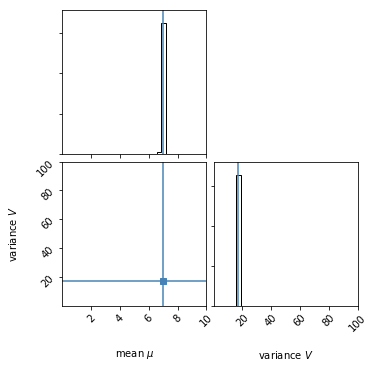

In [11]:
fig = corner(mcmc_samples0, bins=32, labels=[r'mean $\mu$', r'variance $V$'], 
             range=[prior_info[:2], prior_info[2:]], truths=Truth)
             #range=[[6,8], [15, 20]], truths=Truth)

In [12]:
ML_jack = [] 
n_jk = 100
for i_jk in range(n_jk):
    #sub_data = data[i_jk*50:(i_jk+1)*50]
    #sub_data = np.random.choice(data, size=N, replace=True)
    excluded = np.ones(N).astype(bool)
    excluded[i_jk*(N/n_jk):(i_jk+1)*(N/n_jk)] = False
    sub_data = data[excluded]
    assert sub_data.shape[0] == N - N/n_jk
    #draw(Truth, N)
    ln_Li = lambda pars: -1.0 * ln_L0(sub_data, pars)
    ML_i = optimize.minimize(ln_Li, Truth)
    ML_jack.append(ML_i['x'])
ML_jack = np.array(ML_jack)

In [13]:
ML_boot = [] 
n_boot = 100
for i_jk in range(n_boot):
    sub_data = np.random.choice(data, size=N, replace=True)
    ln_Li = lambda pars: -1.0 * ln_L0(sub_data, pars)
    ML_i = optimize.minimize(ln_Li, Truth)
    ML_boot.append(ML_i['x'])
ML_boot = np.array(ML_boot)

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.


(16.0, 18.0)

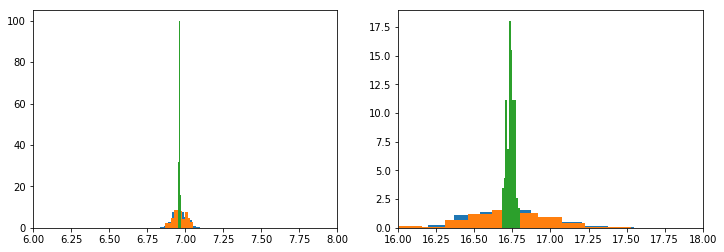

In [14]:
fig = plt.figure(figsize=(12,4))
sub = fig.add_subplot(121)
_ = sub.hist(mcmc_samples0[:,0], color='C0', normed=True)
_ = sub.hist(ML_boot[:,0], color='C1', normed=True)
_ = sub.hist(ML_jack[:,0], color='C2', normed=True)
sub.set_xlim([6., 8.])
sub = fig.add_subplot(122)
_ = sub.hist(mcmc_samples0[:,1], color='C0', normed=True)
_ = sub.hist(ML_boot[:,1], color='C1', normed=True)
_ = sub.hist(ML_jack[:,1], color='C2', normed=True)
sub.set_xlim([16., 18.])

In [24]:
print("True Uncertainty")
print np.var(mcmc_samples0, axis=0)

True Uncertainty
[0.00188869 0.05946417]


In [20]:
print('Jackknife Uncertainty')
print (float(n_jk) - 1)/float(n_jk) * np.sum((ML_jack - np.mean(mcmc_samples0, axis=0))**2, axis=0)

Jackknife Uncertainty
[0.00248644 0.0673094 ]


In [19]:
print('Bootstrap Uncertainty')
print np.var(ML_boot, axis=0)

Bootstrap Uncertainty
[0.00177137 0.06620651]
